# Lab work: Eco-driving

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import math
from geopy.distance import geodesic

Parsed data summary:
GPS data: 1792 records
Accelerometer data: 226183 records
Gyroscope data: 32236 records
Rotation vector data: 7326 records

DETAILED DATA INSPECTION

==================== GPS DATA ====================
Shape: (1792, 8) (rows, columns)
Columns: ['data_type', 'timestamp', 'latitude', 'longitude', 'altitude', 'speed', 'satellites', 'speed_kmh']

GPS missing values:
  data_type: 0
  timestamp: 0
  latitude: 0
  longitude: 0
  altitude: 0
  speed: 0
  satellites: 0
  speed_kmh: 0

GPS basic statistics:
       data_type     timestamp     latitude    longitude     altitude  \
count     1792.0  1.792000e+03  1792.000000  1792.000000  1792.000000   
mean         0.0  1.747222e+09    57.764149    12.001235    11.480915   
std          0.0  5.195074e+02     0.066970     0.012425    19.887072   
min          0.0  1.747222e+09    57.685970    11.980688    -7.600000   
25%          0.0  1.747222e+09    57.695534    11.987949     0.200000   
50%          0.0  1.747222e+09    57.75

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Successfully parsed data, proceeding with analysis...
Parsed data summary:
GPS data: 1792 records
Accelerometer data: 226183 records
Gyroscope data: 32236 records
Rotation vector data: 7326 records
Filling missing values in 'jerk' column
Will cluster data into 3 groups
Checking for missing values...
Missing values in features: speed           0
acceleration    0
jerk            0
turning_rate    0
dtype: int64
PCA completed successfully.
Clustering into 3 groups...


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Analysis completed successfully. Visualizing results...

Feature Importance:
  acceleration: 0.8011
  speed: 0.1593
  driver_cluster_0: 0.0309
  turning_rate: 0.0037
  gradient: 0.0036
  driver_cluster_2: 0.0011
  driver_cluster_1: 0.0004
Driver Cluster: 2
Recommended Actions: {'target_acceleration': 0.72, 'speed_adjustment': 0, 'expected_energy_saving': 53565.55048698187}

Feature Importance for Energy Consumption:
  acceleration: 0.8011
  speed: 0.1593
  driver_cluster_0: 0.0309
  turning_rate: 0.0037
  gradient: 0.0036
  driver_cluster_2: 0.0011
  driver_cluster_1: 0.0004

Eco-Driving Analysis Summary:
  Average Energy Factor: 346997331.13
  Energy Factor Range: 0.00 - 948426194.80

Driver Behavior Clusters:
  Cluster 0:
    Average Speed: 84.93 km/h
    Average Acceleration: 196.67 m/s²
    Energy Efficiency: 353461176.37
  Cluster 1:
    Average Speed: 19.18 km/h
    Average Acceleration: -287.67 m/s²
    Energy Efficiency: 341467120.98
  Cluster 2:
    Average Speed: 16.37 km/h
 

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


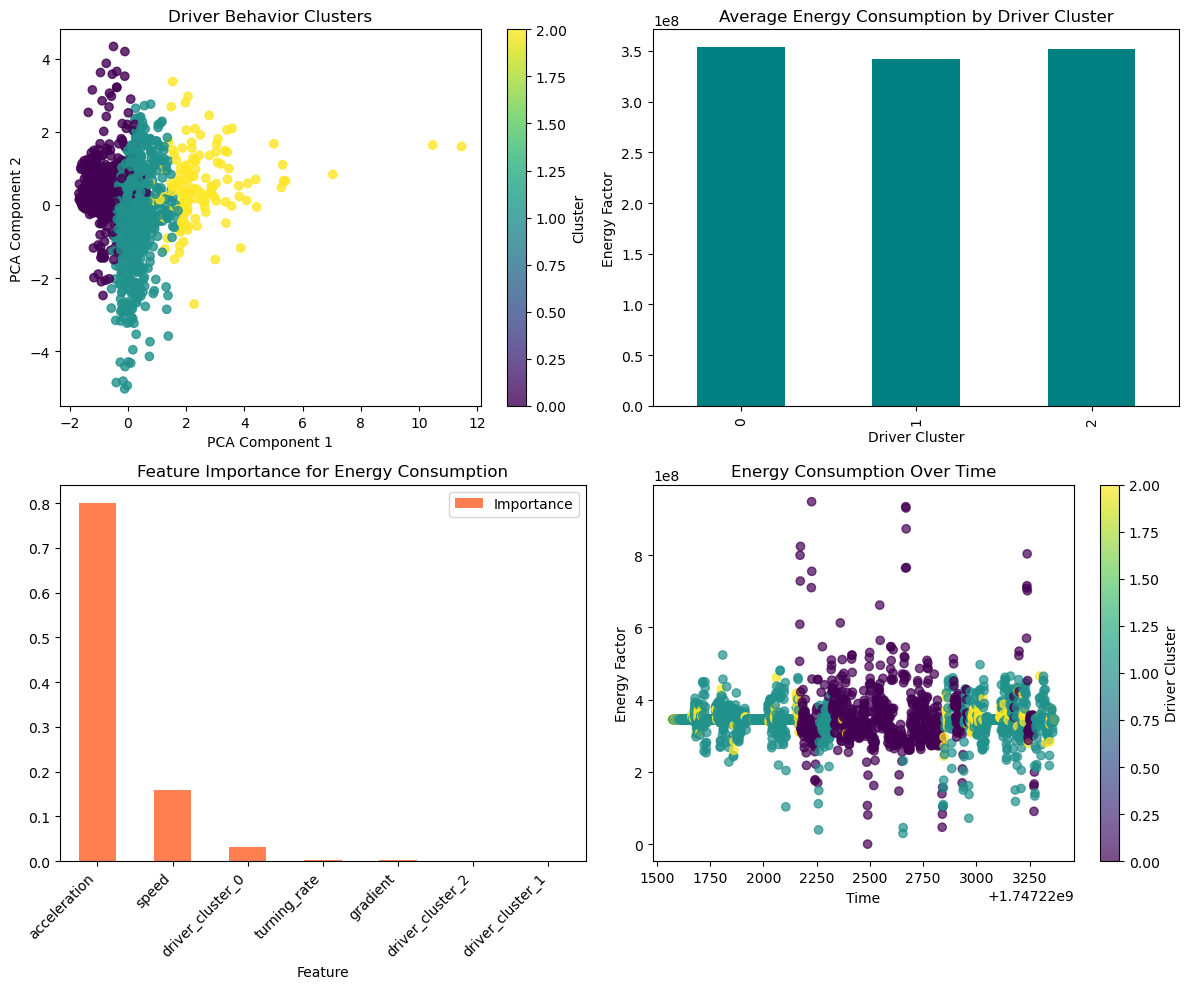

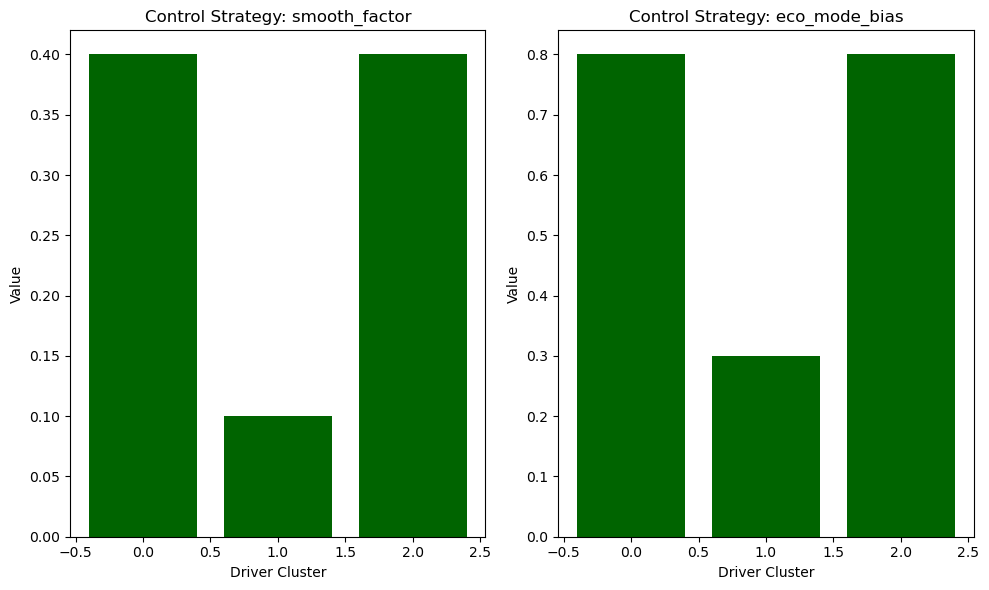

In [ ]:
def parse_data(file_path):
    gps_rows = []
    acc_rows = []  
    gyro_rows = []
    rot_rows = []
    
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(',')
            if len(values) < 2:
                continue
                
            data_type = int(values[0])
                
            if data_type == 0:  
                gps_rows.append(values)
            elif data_type == 1:  
                acc_rows.append(values)
            elif data_type == 2:  
                gyro_rows.append(values)
            elif data_type == 3:  
                rot_rows.append(values)
    
    gps_df = pd.DataFrame()
    if gps_rows:
        gps_df = pd.DataFrame(gps_rows)
        gps_df.columns = ['data_type', 'timestamp', 'latitude', 'longitude', 'altitude', 'speed', 'satellites']
        
        gps_df['data_type'] = gps_df['data_type'].astype(int)
        gps_df['timestamp'] = gps_df['timestamp'].astype(int)
        gps_df['latitude'] = gps_df['latitude'].astype(float)
        gps_df['longitude'] = gps_df['longitude'].astype(float)
        gps_df['altitude'] = gps_df['altitude'].astype(float)
        gps_df['speed'] = gps_df['speed'].astype(float)
        gps_df['satellites'] = gps_df['satellites'].astype(int)
        
        # 将速度从m/s转换为km/h（如果需要）
        gps_df['speed_kmh'] = gps_df['speed'] * 3.6
    
    acc_df = pd.DataFrame()
    if acc_rows:
        acc_df = pd.DataFrame(acc_rows)
        acc_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'x', 'y', 'z']
        acc_df['data_type'] = acc_df['data_type'].astype(int)
        acc_df['timestamp'] = acc_df['timestamp'].astype(int)
        acc_df['timestamp_us'] = acc_df['timestamp_us'].astype(int)
        acc_df['x'] = acc_df['x'].astype(float)
        acc_df['y'] = acc_df['y'].astype(float)
        acc_df['z'] = acc_df['z'].astype(float)
      
        acc_df['x_ms2'] = acc_df['x']
        acc_df['y_ms2'] = acc_df['y'] 
        acc_df['z_ms2'] = acc_df['z'] 
        
    
    gyro_df = pd.DataFrame()
    if gyro_rows:
        gyro_df = pd.DataFrame(gyro_rows)
        gyro_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'x', 'y', 'z']
        gyro_df['data_type'] = gyro_df['data_type'].astype(int)
        gyro_df['timestamp'] = gyro_df['timestamp'].astype(int)
        gyro_df['timestamp_us'] = gyro_df['timestamp_us'].astype(int)
        gyro_df['x'] = gyro_df['x'].astype(float)
        gyro_df['y'] = gyro_df['y'].astype(float)
        gyro_df['z'] = gyro_df['z'].astype(float)
        
        # 陀螺仪数据可能也需要单位转换（如果原始数据不是rad/s）
        # gyro_df['x_rads'] = gyro_df['x'] * conversion_factor
    
    rot_df = pd.DataFrame()
    if rot_rows:
        rot_df = pd.DataFrame(rot_rows)
        rot_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'i', 'j', 'k', 'real']
        
        rot_df['data_type'] = rot_df['data_type'].astype(int)
        rot_df['timestamp'] = rot_df['timestamp'].astype(int)
        rot_df['timestamp_us'] = rot_df['timestamp_us'].astype(int)
        rot_df['i'] = rot_df['i'].astype(float)
        rot_df['j'] = rot_df['j'].astype(float)
        rot_df['k'] = rot_df['k'].astype(float)
        rot_df['real'] = rot_df['real'].astype(float)
    
    print(f"Parsed data summary:")
    print(f"GPS data: {len(gps_df)} records")
    print(f"Accelerometer data: {len(acc_df)} records")
    print(f"Gyroscope data: {len(gyro_df)} records")
    print(f"Rotation vector data: {len(rot_df)} records")
    
    return {
        'gps': gps_df,
        'acc': acc_df,
        'gyro': gyro_df,
        'rot': rot_df
    }
def check_missing_values(data_dict):
    print("\n" + "="*50)
    print("DETAILED DATA INSPECTION")
    print("="*50)
    
    for data_type, df in data_dict.items():
        print(f"\n{'='*20} {data_type.upper()} DATA {'='*20}")
        
        if df.empty:
            print(f"No {data_type} data available.")
            continue
        
        print(f"Shape: {df.shape} (rows, columns)")
        
        print(f"Columns: {list(df.columns)}")
        
        missing = df.isna().sum()
        print(f"\n{data_type.upper()} missing values:")
        for col, count in missing.items():
            print(f"  {col}: {count}")
        
        print(f"\n{data_type.upper()} basic statistics:")
        print(df.describe())
        
        duplicates = df.duplicated().sum()
        print(f"\nDuplicate rows in {data_type} data: {duplicates}")
        
        print(f"\nData validity checks for {data_type} data:")
        
        if data_type == 'gps':
            invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)].shape[0]
            invalid_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)].shape[0]
            print(f"  Invalid latitude values: {invalid_lat}")
            print(f"  Invalid longitude values: {invalid_lon}")
            
            if 'speed' in df.columns:
                extreme_speed = df[df['speed'] > 300].shape[0]
                print(f"  Extreme speed values (>300): {extreme_speed}")
        
        elif data_type == 'acc':
            extreme_acc = df[(df['x'].abs() > 20) | (df['y'].abs() > 20) | (df['z'].abs() > 20)].shape[0]
            print(f"  Extreme acceleration values (>20g): {extreme_acc}")
        
        elif data_type == 'gyro':
            extreme_gyro = df[(df['x'].abs() > 10) | (df['y'].abs() > 10) | (df['z'].abs() > 10)].shape[0]
            print(f"  Extreme angular velocity values (>10rad/s): {extreme_gyro}")
        
        elif data_type == 'rot':
            extreme_rot = df[(df['i'].abs() > 1) | (df['j'].abs() > 1) | (df['k'].abs() > 1)].shape[0]
            print(f"  Potentially unusual rotation vector values: {extreme_rot}")
        
        if 'timestamp' in df.columns:
            is_sorted = df['timestamp'].is_monotonic_increasing
            print(f"  Timestamp in chronological order: {is_sorted}")
            
            if not is_sorted:
                reversed_timestamps = (df['timestamp'].diff() < 0).sum()
                print(f"  Number of reversed timestamp pairs: {reversed_timestamps}")
    
    print("\n" + "="*50)
    print("END OF DATA INSPECTION")
    print("="*50)
def extract_features(data_dict):
    features = {}
    
    if not data_dict['gps'].empty:
        gps_df = data_dict['gps']
        
        distances = []
        gradients = []
        
        for i in range(1, len(gps_df)):
            point1 = (gps_df['latitude'].iloc[i-1], gps_df['longitude'].iloc[i-1])
            point2 = (gps_df['latitude'].iloc[i], gps_df['longitude'].iloc[i])
            distance = geodesic(point1, point2).meters
            distances.append(distance)
            
            if distance > 0:
                elevation_change = gps_df['altitude'].iloc[i] - gps_df['altitude'].iloc[i-1]
                gradient = elevation_change / distance
            else:
                gradient = 0
            gradients.append(gradient)
        
        gps_df.loc[1:, 'distance'] = distances
        gps_df.loc[1:, 'gradient'] = gradients
        gps_df.loc[0, 'distance'] = 0
        gps_df.loc[0, 'gradient'] = 0
        
        gps_df['speed_change'] = gps_df['speed'].diff().fillna(0)
        gps_df['acceleration'] = gps_df['speed_change'] / (gps_df['timestamp'].diff().fillna(1) / 1000)
        
        features['route'] = gps_df
    
    if not data_dict['acc'].empty:
        acc_df = data_dict['acc']
        
        acc_df['magnitude'] = np.sqrt(acc_df['x']**2 + acc_df['y']**2 + acc_df['z']**2)
        
        acc_df['jerk'] = acc_df['magnitude'].diff().fillna(0) / (acc_df['timestamp'].diff().fillna(1) / 1000)
        
        acc_df['jerk_smooth'] = savgol_filter(acc_df['jerk'], 
                                              min(21, len(acc_df) - (len(acc_df) % 2) - 1), 
                                              3)
        
        features['behavior'] = acc_df
    
    if not data_dict['gyro'].empty:
        gyro_df = data_dict['gyro']
        
        gyro_df['turning_rate'] = np.abs(gyro_df['z'])
        
        features['turning'] = gyro_df
    
    return features
def model_energy_consumption(features):
    
    if 'route' in features and 'behavior' in features:
        route_times = features['route']['timestamp'].values
        behavior_times = features['behavior']['timestamp'].values
        
        combined_data = []
        
        for i, row in features['route'].iterrows():
            gps_time = row['timestamp']
            closest_acc_idx = np.argmin(np.abs(behavior_times - gps_time))
            
            entry = {
                'timestamp': gps_time,
                'speed': row['speed'],
                'acceleration': row['acceleration'],
                'gradient': row['gradient'],
                'acc_x': features['behavior']['x'].iloc[closest_acc_idx],
                'acc_y': features['behavior']['y'].iloc[closest_acc_idx],
                'acc_z': features['behavior']['z'].iloc[closest_acc_idx],
                'jerk': features['behavior']['jerk_smooth'].iloc[closest_acc_idx]
            }
            
            if 'turning' in features:
                turning_times = features['turning']['timestamp'].values
                closest_turn_idx = np.argmin(np.abs(turning_times - gps_time))
                entry['turning_rate'] = features['turning']['turning_rate'].iloc[closest_turn_idx]
            else:
                entry['turning_rate'] = 0
                
            combined_data.append(entry)
        
        combined_df = pd.DataFrame(combined_data)
        
        combined_df['energy_factor'] = calculate_energy_factors(combined_df)
        
        return combined_df
    
    return pd.DataFrame()

def calculate_energy_factors(df):
    mass = 2500
    g = 9.81
    rho = 1.225
    Cd = 0.319
    A = 2.54
    Cr = 0.013
    
    energy_factors = np.zeros(len(df))
    
    for i in range(len(df)):
        speed = df['speed'].iloc[i] / 3.6
        
        gradient_angle = np.arctan(df['gradient'].iloc[i])
        rolling_resistance = Cr * mass * g * np.cos(gradient_angle)
        
        aero_drag = 0.5 * rho * Cd * A * speed**2
        
        gradient_resistance = mass * g * np.sin(gradient_angle)
        
        acceleration_resistance = mass * df['acceleration'].iloc[i]
        
        total_resistance = rolling_resistance + aero_drag + gradient_resistance + acceleration_resistance
        
        energy_factors[i] = total_resistance * speed
    
    energy_factors = energy_factors - np.min(energy_factors)
    
    return energy_factors
def cluster_driving_behaviors(combined_data, n_clusters=3):
    """Cluster drivers based on their driving behavior patterns"""
    
    features = ['speed', 'acceleration', 'jerk', 'turning_rate']
    
    for feature in features:
        if feature not in combined_data.columns:
            print(f"Warning: '{feature}' column not found. Adding with default value 0.")
            combined_data[feature] = 0.0
    
    X = combined_data[features]
    
    print("Checking for missing values...")
    missing_values = X.isna().sum()
    print(f"Missing values in features: {missing_values}")
    
    if missing_values.sum() > 0:
        print("Filling missing values with the mean of each column...")
        X = X.fillna(X.mean())
        
        X = X.fillna(0)
        
        print("After filling, missing values:", X.isna().sum())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        print("PCA completed successfully.")
    except Exception as e:
        print(f"Error during PCA: {e}")
        print("Using the first two standardized features instead.")
        X_pca = X_scaled[:, :2]  
    
    n_clusters = min(n_clusters, len(X) - 1) 
    if n_clusters < 1:
        n_clusters = 1
    print(f"Clustering into {n_clusters} groups...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    combined_data['driver_cluster'] = clusters
    
    cluster_profiles = {}
    for cluster in range(n_clusters):
        cluster_data = combined_data[combined_data['driver_cluster'] == cluster]
        
        if len(cluster_data) > 0:
            profile = {
                'avg_speed': cluster_data['speed'].mean(),
                'avg_acceleration': cluster_data['acceleration'].mean(),
                'avg_jerk': cluster_data['jerk'].mean() if 'jerk' in cluster_data else 0.0,
                'avg_turning_rate': cluster_data['turning_rate'].mean() if 'turning_rate' in cluster_data else 0.0,
                'energy_efficiency': cluster_data['energy_factor'].mean() if 'energy_factor' in cluster_data else 0.0
            }
        else:
            profile = {
                'avg_speed': 0.0,
                'avg_acceleration': 0.0,
                'avg_jerk': 0.0,
                'avg_turning_rate': 0.0,
                'energy_efficiency': 0.0
            }
        
        cluster_profiles[cluster] = profile
    
    return combined_data, cluster_profiles, X_pca, clusters
def develop_control_strategy(combined_data, cluster_profiles):
    """Develop adaptive control strategies based on driver clusters"""
    
    features = ['speed', 'acceleration', 'gradient', 'turning_rate', 'driver_cluster']
    for feature in features:
        if feature not in combined_data.columns:
            print(f"Warning: '{feature}' column not found. Adding with default value 0.")
            combined_data[feature] = 0 if feature == 'driver_cluster' else 0.0
    
    if 'energy_factor' not in combined_data.columns:
        print("Warning: 'energy_factor' column not found. Adding with default values.")
        combined_data['energy_factor'] = 10.0  # 默认值
    
    for col in combined_data.columns:
        if combined_data[col].isna().any():
            print(f"Filling missing values in '{col}' column for control strategy development")
            if col == 'driver_cluster':
                combined_data[col] = combined_data[col].fillna(0).astype(int)
            else:
                combined_data[col] = combined_data[col].fillna(combined_data[col].mean() if combined_data[col].notna().any() else 0.0)
    
    X = pd.get_dummies(combined_data[features], columns=['driver_cluster'])
    y = combined_data['energy_factor']
    
    feature_names = list(X.columns)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    feature_importance = dict(zip(X.columns, model.feature_importances_))
    
    control_strategies = {}
    
    for cluster, profile in cluster_profiles.items():
        avg_jerk = profile.get('avg_jerk', 0.0)
        avg_acceleration = profile.get('avg_acceleration', 0.0)
        avg_turning_rate = profile.get('avg_turning_rate', 0.0)
        avg_speed = profile.get('avg_speed', 30.0)
        
        if avg_jerk > 0.5:  
            strategy = {
                'acceleration_smoothing': True,
                'smooth_factor': min(1.0, avg_jerk / 2) if avg_jerk > 0 else 0.5,
                'anticipation_distance': 100 + (avg_speed * 5),
                'eco_mode_bias': 0.7
            }
        elif avg_acceleration > 1.0: 
            strategy = {
                'acceleration_smoothing': True,
                'smooth_factor': 0.4,
                'anticipation_distance': 80 + (avg_speed * 3),
                'eco_mode_bias': 0.8
            }
        elif avg_turning_rate > 0.3:  
            strategy = {
                'acceleration_smoothing': False,
                'smooth_factor': 0.2,
                'anticipation_distance': 120 + (avg_speed * 4),
                'eco_mode_bias': 0.5
            }
        else:  
            strategy = {
                'acceleration_smoothing': False,
                'smooth_factor': 0.1,
                'anticipation_distance': 60 + (avg_speed * 2),
                'eco_mode_bias': 0.3
            }
        
        control_strategies[cluster] = strategy
    
    return model, feature_importance, control_strategies, feature_names
# Main function
def run_eco_driving_analysis(data_file):
    data_dict = parse_data(data_file)
    
    has_data = any(not df.empty for df in data_dict.values())
    if not has_data:
        return "No valid data found in file"
    
    features = extract_features(data_dict)
    
    if not features:
        return "Failed to extract features from data"
    
    combined_data = model_energy_consumption(features)
    
    if combined_data.empty:
        print("Warning: Empty combined data. Attempting to use partial data...")
        if 'route' in features and not features['route'].empty:
            combined_data = features['route'].copy()
            for col in ['acceleration', 'jerk', 'turning_rate', 'energy_factor']:
                if col not in combined_data.columns:
                    combined_data[col] = 0.0
        elif 'behavior' in features and not features['behavior'].empty:
            combined_data = features['behavior'].copy()
            combined_data['speed'] = combined_data.get('speed', 30.0)
            combined_data['acceleration'] = combined_data.get('acceleration', 0.0)
            combined_data['gradient'] = 0.0
            combined_data['turning_rate'] = 0.0
            combined_data['energy_factor'] = combined_data.get('magnitude', 10.0)
    
    if combined_data.empty:
        return "Insufficient data for analysis"
    
    for col in ['speed', 'acceleration', 'jerk', 'turning_rate', 'energy_factor']:
        if col not in combined_data.columns:
            print(f"Adding missing column '{col}' with default values")
            combined_data[col] = 0.0
    
    for col in combined_data.columns:
        if combined_data[col].isna().any():
            print(f"Filling missing values in '{col}' column")
            combined_data[col] = combined_data[col].fillna(combined_data[col].mean() if combined_data[col].notna().any() else 0.0)
    
    n_clusters = min(3, len(combined_data) // 10)
    if n_clusters < 1:
        n_clusters = 1
    
    print(f"Will cluster data into {n_clusters} groups")
    
    clustered_data, cluster_profiles, X_pca, clusters = cluster_driving_behaviors(combined_data, n_clusters)
    
    model, feature_importance, control_strategies, feature_names = develop_control_strategy(clustered_data, cluster_profiles)
    
    results = {
        'data': clustered_data,
        'cluster_profiles': cluster_profiles,
        'pca_data': X_pca,
        'clusters': clusters,
        'energy_model': model,
        'feature_importance': feature_importance,
        'control_strategies': control_strategies,
        'feature_names': feature_names  
    }
    
    return results
# Visualization function
def visualize_results(results):
    """Visualize the results of the eco-driving analysis"""
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(results['pca_data'][:, 0], results['pca_data'][:, 1], 
                         c=results['clusters'], cmap='viridis', alpha=0.8)
    plt.title('Driver Behavior Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    
    plt.subplot(2, 2, 2)
    cluster_energy = results['data'].groupby('driver_cluster')['energy_factor'].mean()
    cluster_energy.plot(kind='bar', color='teal')
    plt.title('Average Energy Consumption by Driver Cluster')
    plt.xlabel('Driver Cluster')
    plt.ylabel('Energy Factor')
    
    plt.subplot(2, 2, 3)
    if results['feature_importance'] and len(results['feature_importance']) > 0:
        importance_df = pd.DataFrame({
            'Feature': list(results['feature_importance'].keys()),
            'Importance': list(results['feature_importance'].values())
        }).sort_values('Importance', ascending=False)
        
        if len(importance_df) > 10:
            importance_df = importance_df.head(10)
        
        if not importance_df.empty:
            importance_df.plot(x='Feature', y='Importance', kind='bar', color='coral', ax=plt.gca())
            plt.title('Feature Importance for Energy Consumption')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
        else:
            plt.text(0.5, 0.5, 'No feature importance data available', 
                    horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.5, 0.5, 'No feature importance data available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.title('Feature Importance for Energy Consumption')
    
    plt.subplot(2, 2, 4)
    if 'timestamp' in results['data'].columns:
        plt.scatter(results['data']['timestamp'], results['data']['energy_factor'], 
                  c=results['data']['driver_cluster'], cmap='viridis', alpha=0.7)
        plt.title('Energy Consumption Over Time')
        plt.xlabel('Time')
        plt.ylabel('Energy Factor')
        plt.colorbar(label='Driver Cluster')
    else:
        plt.scatter(results['data'].index, results['data']['energy_factor'], 
                  c=results['data']['driver_cluster'], cmap='viridis', alpha=0.7)
        plt.title('Energy Consumption by Sample')
        plt.xlabel('Sample Index')
        plt.ylabel('Energy Factor')
        plt.colorbar(label='Driver Cluster')
    
    plt.tight_layout()
    plt.savefig('eco_driving_results.png')
    
    plt.figure(figsize=(10, 6))
    strategies = results['control_strategies']
    clusters = list(strategies.keys())
    
    if strategies and len(strategies) > 0:
        metrics = ['smooth_factor', 'eco_mode_bias']
        for i, metric in enumerate(metrics):
            try:
                values = [strategies[c][metric] for c in clusters]
                plt.subplot(1, 2, i+1)
                plt.bar(clusters, values, color='darkgreen')
                plt.title(f'Control Strategy: {metric}')
                plt.xlabel('Driver Cluster')
                plt.ylabel('Value')
            except (KeyError, TypeError) as e:
                plt.subplot(1, 2, i+1)
                plt.text(0.5, 0.5, f'Error plotting {metric}: {str(e)}', 
                        horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.5, 0.5, 'No control strategy data available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('control_strategies.png')
    
    print("\nFeature Importance:")
    if results['feature_importance'] and len(results['feature_importance']) > 0:
        for feature, importance in sorted(
            results['feature_importance'].items(), 
            key=lambda x: x[1], 
            reverse=True
        ):
            print(f"  {feature}: {importance:.4f}")
    else:
        print("  No feature importance data available")
# Simulation method
class AdaptiveEcoDrivingController:
    def __init__(self, energy_model, control_strategies, feature_names=None):
        self.energy_model = energy_model
        self.control_strategies = control_strategies
        self.feature_names = feature_names  
        self.current_cluster = None
        self.driver_history = []
        self.strategy = None
    
    def update_driver_profile(self, recent_driving_data):
        features = ['speed', 'acceleration', 'jerk', 'turning_rate']
        X = recent_driving_data[features]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        kmeans = KMeans(n_clusters=len(self.control_strategies), random_state=42)
        kmeans.fit(X_scaled)
        
        clusters = kmeans.predict(X_scaled)
        self.current_cluster = np.bincount(clusters).argmax()
        
        self.strategy = self.control_strategies[self.current_cluster]
        
        return self.current_cluster
    def recommend_actions(self, current_state):
        if self.strategy is None:
            return None
        
        state = {
            'speed': current_state.get('speed', 0),
            'gradient': current_state.get('gradient', 0),
            'turning_rate': current_state.get('turning_rate', 0),
            'acceleration': current_state.get('acceleration', 0)
        }
        
        actions = {}
        
        target_acceleration = state['acceleration']
        if self.strategy['acceleration_smoothing']:
            if target_acceleration > 0:
                target_acceleration *= (1 - self.strategy['smooth_factor'])
        
        actions['target_acceleration'] = target_acceleration
        
        if state['gradient'] > 0.03:
            actions['speed_adjustment'] = -max(0, state['speed'] * 0.1 * self.strategy['eco_mode_bias'])
        elif state['gradient'] < -0.03:
            actions['speed_adjustment'] = min(5, state['speed'] * 0.05 * (1 - self.strategy['eco_mode_bias']))
        else:
            actions['speed_adjustment'] = 0
        
        if state['turning_rate'] > 0.2:
            actions['speed_adjustment'] -= state['turning_rate'] * 5 * self.strategy['smooth_factor']
        
        base_energy = self.predict_energy_consumption(state)
        adjusted_state = state.copy()
        adjusted_state['acceleration'] = target_acceleration
        adjusted_state['speed'] += actions['speed_adjustment']
        adjusted_energy = self.predict_energy_consumption(adjusted_state)
        
        actions['expected_energy_saving'] = max(0, base_energy - adjusted_energy)
        
        return actions
    
    def predict_energy_consumption(self, state):
        """Predict energy consumption for a given state"""
        X = pd.DataFrame([state])
        
        for i in range(len(self.control_strategies)):
            X[f'driver_cluster_{i}'] = 1 if i == self.current_cluster else 0
        
        if self.feature_names:
            for feature in self.feature_names:
                if feature not in X.columns:
                    X[feature] = 0  
            X = X[self.feature_names]
        
        energy = self.energy_model.predict(X)[0]
        
        return energy

if __name__ == "__main__":
    data_file = "ts_1747221572.csv"
    
    data_dict = parse_data(data_file)
    
    check_missing_values(data_dict)
    
    results = run_eco_driving_analysis(data_file)
    
    if isinstance(results, str):
        print(f"Analysis error: {results}")
    
    has_data = any(not df.empty for df in data_dict.values())
    
    if not has_data:
        print("No valid data found in the file")
    else:
        print("Successfully parsed data, proceeding with analysis...")
        
        results = run_eco_driving_analysis(data_file)
        
        if isinstance(results, str):
            print(f"Analysis error: {results}")
        else:
            print("Analysis completed successfully. Visualizing results...")
            try:
                visualize_results(results)
                
                controller = AdaptiveEcoDrivingController(
                  results['energy_model'],
                  results['control_strategies'],
                  results.get('feature_names')
                )
                
                sample_state = {
                    'speed': 60,  
                    'gradient': 0.02,  
                    'turning_rate': 0.1, 
                    'acceleration': 1.2 
                }
                
                sample_recent_data = results['data'].tail(100)
                driver_cluster = controller.update_driver_profile(sample_recent_data)
                
                actions = controller.recommend_actions(sample_state)
                
                print(f"Driver Cluster: {driver_cluster}")
                print(f"Recommended Actions: {actions}")
                
                results['data'].to_csv('eco_driving_data.csv', index=False)
                
                with open('cluster_profiles.txt', 'w') as f:
                    for cluster, profile in results['cluster_profiles'].items():
                        f.write(f"Cluster {cluster}:\n")
                        for key, value in profile.items():
                            f.write(f"  {key}: {value:.4f}\n")
                        f.write("\n")
                
                with open('control_strategies.txt', 'w') as f:
                    for cluster, strategy in results['control_strategies'].items():
                        f.write(f"Cluster {cluster}:\n")
                        for key, value in strategy.items():
                            f.write(f"  {key}: {value}\n")
                        f.write("\n")
                        
                print("\nFeature Importance for Energy Consumption:")
                for feature, importance in sorted(
                    results['feature_importance'].items(), 
                    key=lambda x: x[1], 
                    reverse=True
                ):
                    print(f"  {feature}: {importance:.4f}")
                
                print("\nEco-Driving Analysis Summary:")
                energy_data = results['data']['energy_factor']
                print(f"  Average Energy Factor: {energy_data.mean():.2f}")
                print(f"  Energy Factor Range: {energy_data.min():.2f} - {energy_data.max():.2f}")
                
                print("\nDriver Behavior Clusters:")
                for cluster, profile in results['cluster_profiles'].items():
                    print(f"  Cluster {cluster}:")
                    print(f"    Average Speed: {profile['avg_speed']:.2f} km/h")
                    print(f"    Average Acceleration: {profile['avg_acceleration']:.2f} m/s²")
                    print(f"    Energy Efficiency: {profile['energy_efficiency']:.2f}")
                
                print("\nEco-driving analysis and visualization completed successfully!")
                print("Results saved to:")
                print("  - eco_driving_data.csv")
                print("  - cluster_profiles.txt")
                print("  - control_strategies.txt")
                print("  - eco_driving_results.png")
                print("  - control_strategies.png")
                
            except Exception as e:
                print(f"Error during visualization or processing: {e}")
                import traceback
                traceback.print_exc()
